Небольшой шаблон, чтобы вам было легче ориентироваться в том, как сделать PCA в питоне.

In [1]:
import os
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


from scipy.stats import norm
from sklearn.decomposition import PCA # Основной класс, который нам нужен
from sklearn.preprocessing import StandardScaler # Стандартизация, обязательно воспользуйтесь именно этим классом

In [2]:
plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
warnings.filterwarnings("ignore")
np.random.seed(42)

### Загрузим данные (транскриптомика)

In [3]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/scRNAseq_CITEseq.txt -O scRNAseq_CITEseq.txt

--2021-11-21 16:03:53--  https://kodomo.fbb.msu.ru/FBB/year_20/scRNAseq_CITEseq.txt
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17128751 (16M) [text/plain]
Saving to: ‘scRNAseq_CITEseq.txt’

scRNAseq_CITEseq.tx 100%[===================>]  16,33M  11,2MB/s    in 1,5s    

2021-11-21 16:03:56 (11,2 MB/s) - ‘scRNAseq_CITEseq.txt’ saved [17128751/17128751]



In [4]:
scRNAseq = pd.read_csv("scRNAseq_CITEseq.txt", sep="\t")
X_scRNAseq = scRNAseq.iloc[:, 0:(scRNAseq.shape[1] - 1)]
Y_scRNAseq = scRNAseq.iloc[:, scRNAseq.shape[1] - 1]
X_scRNAseq = np.log(X_scRNAseq + 1)
scRNAseq.shape

(8617, 977)

In [5]:
# Создаем класс PCA, указывая нужное число компонент
# Можно не указывать ничего, тогда будет вычисленно
# столько компонент, сколько у вас признаков, но это может быть долго :)
pca = PCA(n_components=X_scRNAseq.shape[1])

# Метод fit вычисляет коэффициенты для PC
pca.fit(X_scRNAseq)

# Чтобы трансформировать данные нужно сделать следующее:
# X_reduced = pca.transform(X_scRNAseq) (также есть метод fit_transform)

PCA(n_components=976)

### Глянем, сколько нужно взять PC

#### 1. Вариант

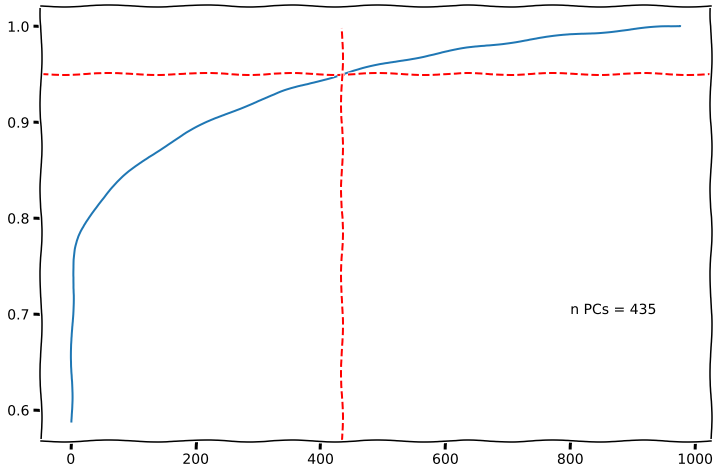

In [12]:
ths = 0.95
total_explained = np.cumsum(pca.explained_variance_ratio_)


with plt.xkcd():
    plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained)
    plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
    chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
    plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
    plt.text(800, 0.7, f"n PCs = {chosen_number}", clip_on=True);

#### 2. Вариант

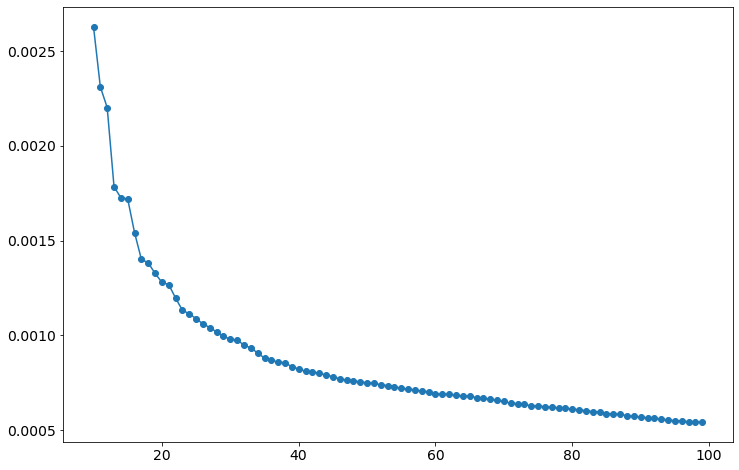

In [13]:
# Он здесь очень плохо подходит, так как слишком много признаков
plt.scatter(np.arange(10, 100), pca.explained_variance_ratio_[10:100])
plt.plot(np.arange(10, 100), pca.explained_variance_ratio_[10:100])
plt.show()

#### 3. Вариант

Тут много кода, но на лекции мы обсудили, что все довольно просто: мы перемешиваем столбцы в данных, считаем PCA и получаем, какую долю дисперсии объясняет каждая компонента для случайных данных. Дальше делаем так много раз, чтобы получить какое-то распределение и потом для наших изначальных данных выбираем только те компоненты, которые объясняют больше дисперсии, чем компоненты с теми же номерами для случайных данных.

In [27]:
def shuffle_dataset(dataset):
    """
    Мешаем данные
    """
    random_data =  {}
    for col in dataset.columns:
        random_data[col] = np.random.permutation(dataset.loc[:, col].values)
    random_data = pd.DataFrame(random_data)
    
    return random_data


def get_variance_by_chance(dataset, n_replics, n_components):
    """
    Считаем, сколько дисперсии объясняет каждая PC для перемешанных данных
    """
    variance_explained_by_chance = np.zeros((n_replics, n_components))
    
    for i in tqdm.tqdm_notebook(range(n_replics)):
        if i % 100 == 0:
            print(f"{i} iter")

        random_data = shuffle_dataset(dataset)
        random_pca = PCA(n_components=n_components)
        random_pca.fit(random_data)
        variance_explained_by_chance[i, :] = random_pca.explained_variance_ratio_
        
    return variance_explained_by_chance


def get_pc_variance(dataset, n_components):
    """
    Считаем, сколько дисперсии объясняет каждая PC для реальных данных
    """
    pca = PCA(n_components=n_components)
    pca.fit(dataset)
    
    return pca.explained_variance_ratio_


# Дальше идет ряд графиков для визуализации

def plot_mean_and_ci(ax, values, label, ci_level=0.95, alpha_transparency=0.5, color_mean=None, color_shading=None):
    mean = values.mean(axis=0)
    
    std = values.std(axis=0)
    n = values.shape[1]
    se = std / np.sqrt(n) 
    
    q_alpha = (1-ci_level) / 2
    ci_num = np.abs(norm.ppf(q_alpha, loc=0, scale=1))
    
    lb = mean -  ci_num * se
    ub = mean + ci_num * se
    
    ax.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=alpha_transparency)
    
    ax.plot(mean, c=color_mean, lw=3, label=label)
    
    
def plot_explained_variance(ax, variance):
    ax.plot(variance, label="real", lw=3)
    ax.scatter(np.arange(0, variance.shape[0]), variance)
    
    
def plot_variance_by_change(ax, variance_by_chance):
    plot_mean_and_ci(ax, variance_by_chance, label="chance", color_mean="red", color_shading="red")


def plot_explained_vs_chance(ax, explained_variance, variance_by_chance, dataset_name, step=1):
    plot_explained_variance(ax, explained_variance)
    plot_variance_by_change(ax, variance_by_chance)

    ax.set_title(f"PCA {dataset_name}", size=35)
    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("Explained variance ratio", size=25)
    ax.set_xticks(np.arange(0, explained_variance.shape[0], step))
    ax.set_xticklabels(np.arange(1, explained_variance.shape[0]+1, step), size=20)

    ax.tick_params(labelsize=20, size=10)
    ax.set_ylim(0, explained_variance[0] + 0.1 )
    ax.legend(fontsize=20)

    
def plot_pval_plot(ax, p_values, dataset_name, alpha_level = 0.05, logscale=True, step=1):
    if logscale:
        p_values = -np.log10(p_values)
        alpha_level = -np.log10(alpha_level)

    
    ax.set_title(f"PC significance, {dataset_name}", size=35)
    ax.plot(p_values, lw=3)
    ax.scatter(np.arange(0, p_values.shape[0]), p_values, lw=3)

    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("-log(pvalue + eps)", size=25)
    ax.set_xticks(np.arange(0, p_values.shape[0], step))
    
    ax.set_xticklabels(labels = np.arange(1, p_values.shape[0]+1, step), size=20)
    ax.tick_params(labelsize=20, size=10)
    

    ax.hlines(y=alpha_level, xmin=0, xmax=p_values.shape[0], color="red", linestyles="dashed", lw=3)


def calc_permutat_pval(real_values, permut_values, eps=None):
    """
    Сравниваем долю объясненной дисперсии для реальных данных и для перемешанных
    """
    eps = eps or (1 / (permut_values.shape[0] * 10))
    
    p_values = np.zeros_like(real_values)
    for i in range(0, p_values.shape[0], 1):
        p_values[i] = (permut_values[:, i] >= real_values[i]).mean() + eps
    return p_values

    
def pca_analysis(ax1, ax2, dataset, title, n_components = None, n_replics = 1000, step=1):
    """
    Главная функция, которая просто запускает все, что выше
    """
    n_components = n_components or dataset.shape[1]
    explained_variance = get_pc_variance(dataset, n_components)
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)
    plot_explained_vs_chance(ax1, explained_variance, variance_by_chance, title)
    plot_pval_plot(ax2, p_values, title)

  0%|          | 0/10 [00:00<?, ?it/s]

0 iter


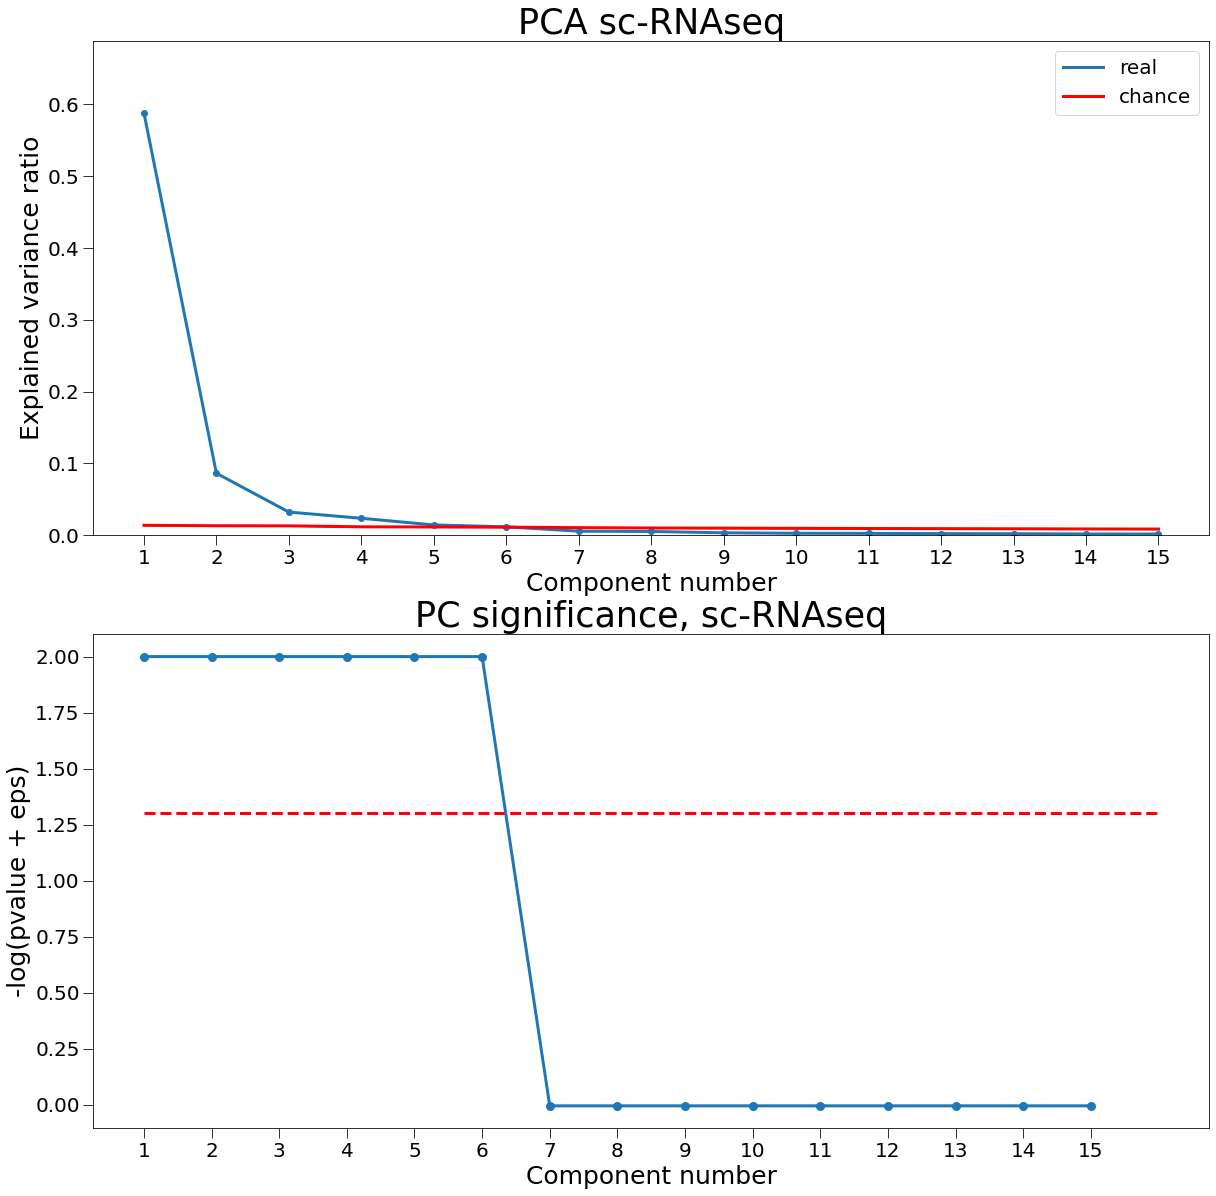

In [29]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, X_scRNAseq, "sc-RNAseq", n_replics=10, n_components=15)

То есть получается, данный подход говорит нам о том, что лучше всего оставить 6 PC. В сумме они оьъясняют около 76% дисперсии (переменная total_explained)

Мы забыли сделать одну вещь: стандартизация, может быть в данном случае это было не критично и результат бы был не сильно другой, но лучше все же ее применять.

In [34]:
X_scaled = StandardScaler().fit_transform(scRNAseq)

In [44]:
pca = PCA(n_components=X_scRNAseq.shape[1])
pca.fit(X_scaled)

PCA(n_components=976)

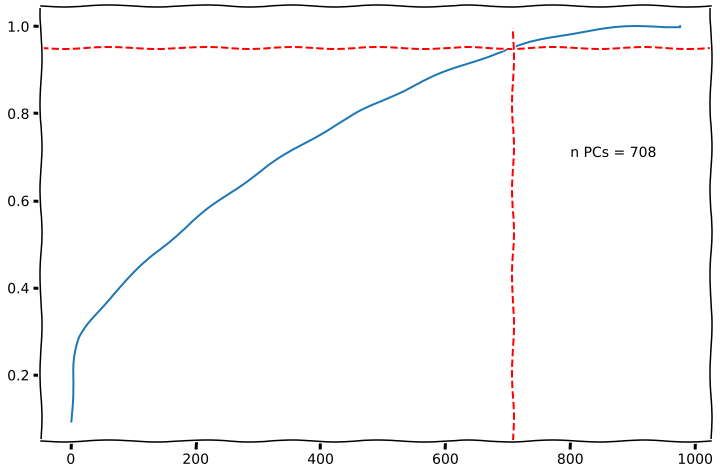

In [45]:
ths = 0.95
total_explained = np.cumsum(pca.explained_variance_ratio_)


with plt.xkcd():
    plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained)
    plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
    chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
    plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
    plt.text(800, 0.7, f"n PCs = {chosen_number}", clip_on=True);

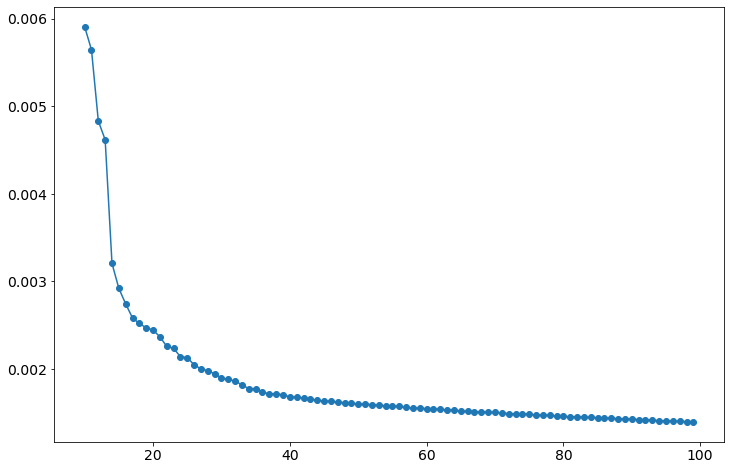

In [47]:
plt.scatter(np.arange(10, 100), pca.explained_variance_ratio_[10:100])
plt.plot(np.arange(10, 100), pca.explained_variance_ratio_[10:100])
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

0 iter


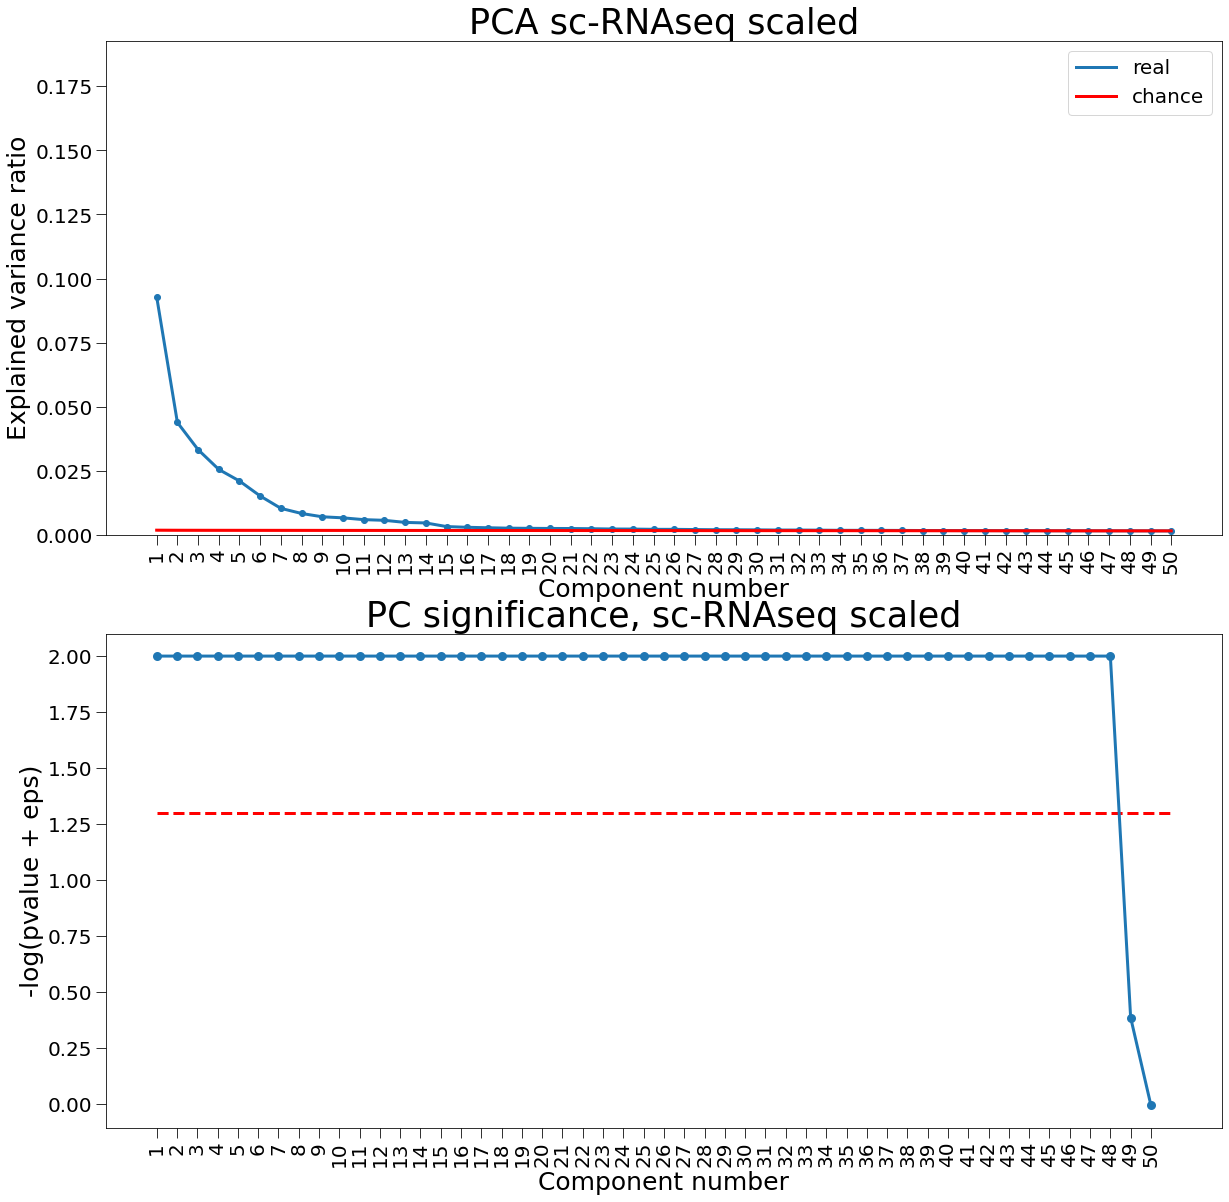

In [43]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, pd.DataFrame(X_scaled), "sc-RNAseq scaled", n_replics=10, n_components=50)
ax1.set_xticklabels(np.arange(1, 51), rotation=90)
ax2.set_xticklabels(np.arange(1, 51), rotation=90);

Почему так произошло, ведь у нас все величины имеют одинаковую размерность и тд? Оказывается, что есть высоковариабельные гены, с высокой дисперсией их экпрессии и они оказывали большее влияние на выбор первых компонент. Во втором случае результаты вышли совершенно другие.

Что теперь с этим всем делать? Для начала можно трансформировать с помощью главных компонент наши данные и нарисовать в 2D. Также можно новые признаки использовать для какой-то линейной модели, если, например, у вас для каждой клетки известно, к какому типу она пренадлежит, то можно сделать классификацию.